# Working with Bag of Words

-------------------------------------

In this example, we will download and preprocess the ham/spam text data.  We will then use a one-hot-encoding to make a bag of words set of features to use in logistic regression.

We will use these one-hot-vectors for logistic regression to predict if a text is spam or ham.

We start by loading the necessary libraries.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()

We start a computation graph session.

In [2]:
# Start a graph session
sess = tf.Session()

Check if data was downloaded, otherwise download it and save for future use

In [5]:
save_file_name = os.path.join('temp','temp_spam_data.csv')

# Create directory if it doesn't exist
if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

To reduce the potential vocabulary size, we normalize the text. To do this, we remove the influence of capitalization and numbers in the text.

In [12]:
# Relabel 'spam' as 1, 'ham' as 0
target = [1 if x=='spam' else 0 for x in target]

# Normalize text
# Lower case
texts = [x.lower() for x in texts]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

To determine a good sentence length to pad/crop at, we plot a histogram of text lengths (in words).

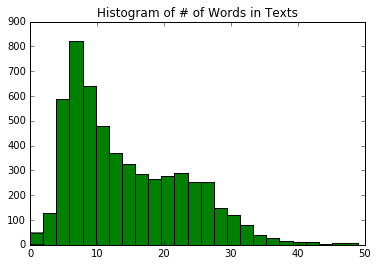

In [14]:
# Plot histogram of text lengths
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
plt.show()

We crop/pad all texts to be 25 words long.  We also will filter out any words that do not appear at least 3 times.

In [15]:
# Choose max text word length at 25
sentence_size = 25
min_word_freq = 3

TensorFlow has a built in text processing function called `VocabularyProcessor()`. We use this function to process the texts.

In [16]:
# Setup vocabulary processor
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)

# Have to fit transform to get length of unique words.
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)

To test our logistic model (predicting spam/ham), we split the texts into a train and test set.

In [17]:
# Split up data set into train/test
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

For one-hot-encoding, we setup an identity matrix for the TensorFlow embedding lookup.

We also create the variables and placeholders for the logistic regression we will perform.

In [18]:
# Setup Index Matrix for one-hot-encoding
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

Next, we create the text-word embedding lookup with the prior identity matrix.

Our logistic regression will use the counts of the words as the input.  The counts are created by summing the embedding output across the rows.

Then we declare the logistic regression operations. Note that we do not wrap the logistic operations in the sigmoid function because this will be done in the loss function later on.

In [20]:
# Text-Vocab Embedding
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

# Declare model operations
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

Now we declare our loss function (which has the sigmoid built in), prediction operations, optimizer, and initialize the variables.

In [21]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Prediction operation
prediction = tf.sigmoid(model_output)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

Now we loop through the iterations and fit the logistic regression on wether or not the text is spam or ham.

In [22]:
# Start Logistic Regression
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
        
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 4459 Sentences.
Training Observation #10: Loss = 6.48148e-09
Training Observation #20: Loss = 27.843
Training Observation #30: Loss = 5.70256
Training Observation #40: Loss = 32.9266
Training Observation #50: Loss = 29.7551
Training Observation #60: Loss = 23.1056
Training Observation #70: Loss = 2.52858
Training Observation #80: Loss = 18.3234
Training Observation #90: Loss = 17.5812
Training Observation #100: Loss = 13.6586
Training Observation #110: Loss = 3.12693
Training Observation #120: Loss = 7.68214
Training Observation #130: Loss = 8.74553
Training Observation #140: Loss = 0.0183878
Training Observation #150: Loss = 3.11211
Training Observation #160: Loss = 1.52756
Training Observation #170: Loss = 1.56842
Training Observation #180: Loss = 1.61541e-05
Training Observation #190: Loss = 1.4735
Training Observation #200: Loss = 0.0730168
Training Observation #210: Loss = 0.484521
Training Observation #220: Loss = 0.00873441
Training Observation #230: Loss 

Now that we have a logistic model, we can evaluate the accuracy on the test dataset.

In [23]:
# Get test set accuracy
print('Getting Test Set Accuracy For {} Sentences.'.format(len(texts_test)))
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if (ix+1)%50==0:
        print('Test Observation #' + str(ix+1))    
    
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)

print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy For 1115 Sentences.
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy: 0.8179372197309417


Let's look at the training accuracy over all the iterations.

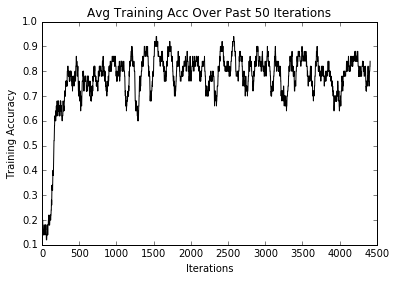

In [24]:
# Plot training accuracy over time
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.show()

It is worthwhile to mention the motivation of limiting the sentence (or text) size.  In this example we limited the text size to 25 words.  This is a common practice with bag of words because it limits the effect of text length on the prediction.  You can imagine that if we find a word, “meeting” for example, that is predictive of a text being ham (not spam), then a spam message might get through by putting in many occurrences of that word at the end.  In fact, this is a common problem with imbalanced target data.  Imbalanced data might occur in this situation, since spam may be hard to find and ham may be easy to find.  Because of this fact, our vocabulary that we create might be heavily skewed toward words represented in the ham part of our data (more ham means more words are represented in ham than spam).  If we allow unlimited length of texts, then spammers might take advantage of this and create very long texts, which have a higher probability of triggering non-spam word factors in our logistic model.

In the next section, we attempt to tackle this problem in a better way using the frequency of word occurrence to determine the values of the word embeddings.